In [2]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
%matplotlib inline
from celmech import Andoyer
from tqdm import tqdm
import numpy as np
from celmech.andoyer import get_Hsep
import rebound

In [3]:
params_rv = np.load('stability_posteriors/100k_rv_priors_60mil_lnlike_randomtheta.npy')
preds_rv = np.load('stability_posteriors/100k_rv_stability_preds_randomtheta.npy')

In [4]:
params_rv[0]

array([ 1.52378762e-02,  6.05336544e-03, -4.63498788e+00,  6.60322300e+01,
       -3.22161308e+00,  2.46711955e-01])

In [5]:
m_b_rv = [param[-2] for param in params_rv]
e_b_rv = [param[-1] for param in params_rv]

params_cd = [list(params_rv[i][:4]) for i in range(len(params_rv))]
#deltaTs = [params_rv[i][-2] for i in range(len(params_rv))]

#for p1,p2 in zip(params_cd, deltaTs):
#    p1.append(p2)
    
params_b = [[m_b, e_b] for m_b, e_b in zip(m_b_rv, e_b_rv)]

In [6]:
def makesim(param_cd, param_b, seed, dt=None):
    sim = makesimcd(param_cd[:4], dt=dt)
    
    m_b = 10**param_b[0]
    e_b = param_b[1]
    np.random.seed(seed)
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=theta_b)
    sim.move_to_com()
    return sim

def makesimcd(param_cd,dt=None):
    e_forced, e_free, mu, deltaT = param_cd
    if dt:
        deltaT = dt
    mratio=0.5
    e_com = 0.0
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=0, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise

def phi_3body(param_cd, param_b, seed):
    sim = makesim(param_cd, param_b, seed)
    ps = sim.particles
    
    Nout = 3000
    times = np.linspace(0, 1000*sim.particles[1].P, Nout)
    phi = np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        phi[i] = ps[1].l - 2*ps[2].l + ps[3].l
    return times, phi

def librates(phi):
    cphi = np.cos(phi)
    Npts = 20
    ranges = np.linspace(-1, 1, Npts)
    librates = False
    for i in range(Npts-1):
        idxs = np.where((cphi>=ranges[i]) & (cphi<=ranges[i+1]))[0]
        if len(idxs) == 0:
            librates = True
            break
    return librates

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

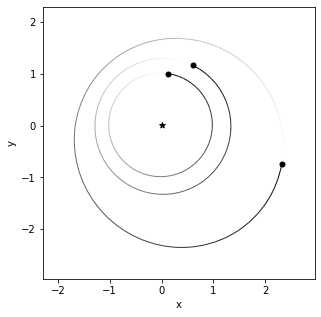

In [7]:
# idx now corresponds to the index AND the seed used when sampling, so pomega_b and theta_b should be the same
idx = 42
#np.random.seed(ctr)
#ctr += 1
pcd = params_cd[idx]
pb = params_b[idx]

sim = makesim(pcd, pb, seed=idx)
rebound.OrbitPlot(sim)

(-1.0, 1.0)

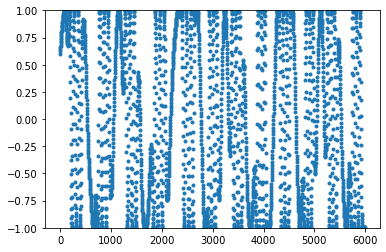

In [8]:
times, phi = phi_3body(pcd, pb, seed=idx)
fig, ax = plt.subplots()
ax.plot(times, np.cos(phi), '.')
ax.set_ylim([-1, 1])

In [9]:
librates(phi)

False

In [10]:
librates(phi_3body(pcd, pb, seed=idx)[-1])

False

## Looping over each configuration, index is seed for $\varpi_b$ and $\theta_b$

In [ ]:
librating_arr = []
pbar = tqdm(total=len(params_rv))
for i,(pcd,pb) in enumerate(zip(params_cd, params_b)):
    if i == 66986:
        continue
    libr = librates(phi_3body(pcd, pb, seed=i)[-1])
    librating_arr.append(libr)
    pbar.update()
pbar.close()

  0%|          | 64/100000 [00:08<3:39:10,  7.60it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
 59%|█████▉    | 58957/100000 [2:06:34<1:25:48,  7.97it/s]

In [11]:
idx = 78986
librates(phi_3body(params_cd[idx], params_b[idx], seed=idx)[-1])

False